In [1]:
import os
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer

In [2]:
df = pd.read_csv("../input/features.csv")

In [3]:
df.head()

,ip,user_agent,session,num_requests,img_to_req(%),4xx(%),Head(%),std_path_length,consq_rep_path(%),ave_response_len,sum_response_len,ave_response_time,sum_response_time,session_duration,ave_time_per_page,robot_txt,is_bot
0,1.81.122.235,Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like M...,0,7,0.000000,0.0,0.0,0.000000,85.714286,108702.714286,760919,41.714286,292.0,6.900000,1.150000,0,0
1,10.92.2.8,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,0,28,28.571429,0.0,0.0,0.507875,71.428571,48159.571429,1348468,25.428571,712.0,0.166667,0.006173,0,0
2,100.92.35.41,Mozilla/5.0 (Linux; Android 9; SM-A205F) Apple...,0,12,0.000000,0.0,0.0,0.834847,50.000000,100601.416667,1207217,26.333333,316.0,0.216667,0.019697,0,0
3,102.0.232.185,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0,16,0.000000,0.0,0.0,0.516398,87.500000,181.625000,2906,82738.750000,1323820.0,23.100000,1.540000,0,0
4,102.0.232.220,Mozilla/5.0 (Linux; Android 11; SM-A505F) Appl...,0,14,35.714286,0.0,0.0,0.267261,57.142857,56852.428571,795934,14.571429,204.0,0.116667,0.008974,0,0


In [4]:
cols_to_model = df.drop(["ip", "user_agent", "session"], axis = 1).columns
cols_to_scale = df.drop(["ip", "user_agent","session", "robot_txt", "is_bot"], axis=1).columns

In [5]:
temp_quantile = df.copy()
scaler = QuantileTransformer(output_distribution="normal", n_quantiles=1000)
temp_quantile[cols_to_scale] = scaler.fit_transform(temp_quantile[cols_to_scale])

In [6]:
pca_QuantileTransformer = PCA(n_components=3) 
pca_QuantileTransformer.fit(temp_quantile[cols_to_model]) 
pca_3d_QuantileTransformer = pca_QuantileTransformer.transform(temp_quantile[cols_to_model])

In [7]:
pca_QuantileTransformer.explained_variance_ratio_

array([0.32353837, 0.25529975, 0.1162171 ])

In [8]:
pca_df = pd.DataFrame(pca_3d_QuantileTransformer, columns=["PCA_1", "PCA_2", "PCA_3"])

In [9]:
index_r = pca_df[pca_df["PCA_1"] > 2.5].index
index_l = pca_df[pca_df["PCA_1"] < 2.5].index

right_df = temp_quantile.loc[index_r]
left_df = temp_quantile.loc[index_l]

In [10]:
right_df.shape, left_df.shape

((5325, 17), (25358, 17))

In [11]:
contaminations = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15,0.2,0.3,0.4]

In [12]:
result = []

for i in contaminations:
    
    iso_model = IsolationForest(n_estimators=200, 
                                  max_samples= 128,
                                  contamination= i,
                                  max_features=1.0,
                                  n_jobs=-1,
                                  random_state=123,
                                  verbose=0)

    iso_model.fit(right_df[cols_to_model])

    anomaly_prediction = iso_model.predict(right_df[cols_to_model])
#         anomaly_score = iso_model.decision_function(df[cols_to_model])

    right_df["anomaly"] = anomaly_prediction
#         df["anomaly_score"] = anomaly_score

    row = {"Num_Normal": sum(1 for j in anomaly_prediction if j == 1),
           "Num_Anomalies": sum(1 for k in anomaly_prediction if k == -1),
           "Contamination" : str(i),
           "model": iso_model
          }

    result.append(row)

    right_df.drop(["anomaly"], axis=1, inplace=True)

result_r = pd.DataFrame(result)    
result_r.set_index(["Contamination"], inplace=True)
result_r
    

,Num_Normal,Num_Anomalies,model
Contamination,,,
0.01,5271,54,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.02,5218,107,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.03,5165,160,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.04,5112,213,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.05,5058,267,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.06,5005,320,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.07,4952,373,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.08,4899,426,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.09,4845,480,"(ExtraTreeRegressor(max_depth=7, max_features=..."


In [13]:
result = []

for i in contaminations:
    
    iso_model = IsolationForest(n_estimators=200, 
                                  max_samples= 128,
                                  contamination= i,
                                  max_features=1.0,
                                  n_jobs=-1,
                                  random_state=123,
                                  verbose=0)

    iso_model.fit(left_df[cols_to_model])

    anomaly_prediction = iso_model.predict(left_df[cols_to_model])
#         anomaly_score = iso_model.decision_function(df[cols_to_model])

    left_df["anomaly"] = anomaly_prediction
#         df["anomaly_score"] = anomaly_score

    row = {"Num_Normal": sum(1 for j in anomaly_prediction if j == 1),
           "Num_Anomalies": sum(1 for k in anomaly_prediction if k == -1),
           "Contamination" : str(i),
           "model": iso_model
          }

    result.append(row)

    left_df.drop(["anomaly"], axis=1, inplace=True)

result_l = pd.DataFrame(result)    
result_l.set_index(["Contamination"], inplace=True)
result_l

,Num_Normal,Num_Anomalies,model
Contamination,,,
0.01,25104,254,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.02,24850,508,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.03,24603,755,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.04,24343,1015,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.05,24090,1268,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.06,23836,1522,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.07,23586,1772,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.08,23329,2029,"(ExtraTreeRegressor(max_depth=7, max_features=..."
0.09,23075,2283,"(ExtraTreeRegressor(max_depth=7, max_features=..."


In [14]:
iso_model_r = result_r.loc["0.1"]["model"] 

iso_model_r.fit(right_df[cols_to_model])

right_df["is_anomaly"] = iso_model_r.predict(right_df[cols_to_model])
right_df["anomaly_score"] = iso_model_r.decision_function(right_df[cols_to_model])

right_df[right_df["is_anomaly"] == -1].head()

,ip,user_agent,session,num_requests,img_to_req(%),4xx(%),Head(%),std_path_length,consq_rep_path(%),ave_response_len,sum_response_len,ave_response_time,sum_response_time,session_duration,ave_time_per_page,robot_txt,is_bot,is_anomaly,anomaly_score
2,100.92.35.41,Mozilla/5.0 (Linux; Android 9; SM-A205F) Apple...,0,-0.849874,-5.199338,-5.199338,-5.199338,1.948397,-1.310017,2.375697,0.794569,0.517885,0.313694,0.008782,0.176514,0,0,-1,-0.022818
24,102.113.30.142,Go-http-client/1.1,0,-1.597698,-5.199338,5.199338,-5.199338,-5.199338,1.304121,-5.199338,-5.199338,-0.510631,-1.533612,0.109365,0.502515,0,1,-1,-0.083471
153,109.165.215.198,FreshpingBot/1.0 (+https://freshping.io/),0,2.836915,-5.199338,-5.199338,-5.199338,-5.199338,3.424737,1.858110,2.880791,0.558353,0.746422,3.663723,1.220153,0,1,-1,-0.085874
158,109.39.88.125,FreshpingBot/1.0 (+https://freshping.io/),0,2.836069,-5.199338,-5.199338,-5.199338,-5.199338,3.424231,1.858109,2.880378,0.560013,0.748753,3.660038,1.220662,0,1,-1,-0.085874
260,113.111.159.120,MoziIIa/5.0 (X11; Linux x86_64) app_version: 581,0,-5.199338,-5.199338,2.575483,-5.199338,0.235509,-1.310017,-0.552277,-1.057201,0.033880,-1.228607,0.976139,1.507784,0,0,-1,-0.027123


In [15]:
iso_model_l = result_r.loc["0.1"]["model"] 

iso_model_l.fit(left_df[cols_to_model])

left_df["is_anomaly"] = iso_model_l.predict(left_df[cols_to_model])
left_df["anomaly_score"] = iso_model_l.decision_function(left_df[cols_to_model])

left_df[left_df["is_anomaly"] == -1].head()

,ip,user_agent,session,num_requests,img_to_req(%),4xx(%),Head(%),std_path_length,consq_rep_path(%),ave_response_len,sum_response_len,ave_response_time,sum_response_time,session_duration,ave_time_per_page,robot_txt,is_bot,is_anomaly,anomaly_score
9,102.105.139.132,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0,3.091742,-0.932227,1.813142,-5.199338,1.014061,2.793740,-0.348740,2.546791,2.048466,3.216732,2.56365,0.703141,0,0,-1,-0.134986
11,102.105.193.47,Mozilla/5.0 (Linux; Android 10; Redmi Note 9 P...,0,-1.002056,-0.404717,-5.199338,-5.199338,0.023839,-0.833781,-5.199338,-5.199338,-2.511791,-2.542349,-0.77145,-0.154930,0,0,-1,-0.078326
13,102.105.22.17,Mozilla/5.0 (Linux; Android 9; Redmi Note 8 Pr...,0,-0.443149,0.733156,-5.199338,-5.199338,-0.370902,0.208505,-5.199338,-5.199338,-1.902873,-1.649237,-0.77145,-0.616541,0,0,-1,-0.038242
17,102.105.47.241,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0,-1.236652,-0.665852,2.728850,-5.199338,3.106381,-0.786745,1.862670,-0.110575,2.703808,1.897176,1.46786,1.820576,0,0,-1,-0.102531
18,102.105.50.239,Mozilla/5.0 (Linux; Android 7.1.1; LG-M700) Ap...,0,-1.002056,-0.404717,-5.199338,-5.199338,0.023839,-0.833781,-5.199338,-5.199338,-1.575613,-1.773922,-0.77145,-0.154930,0,0,-1,-0.044842


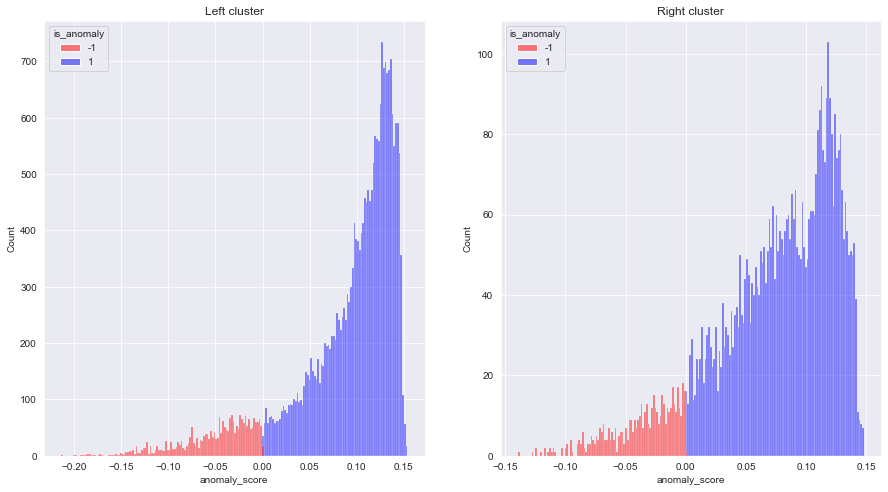

In [16]:
# Histogram of anomaly scores
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(121)
sns.histplot(data = left_df, x="anomaly_score", bins = 200, hue="is_anomaly", palette=["r", "b"])
plt.title("Left cluster")
ax = fig.add_subplot(122)
sns.histplot(data = right_df, x="anomaly_score", bins = 200, hue="is_anomaly", palette=["r", "b"])
plt.title("Right cluster")
plt.show()

In [17]:
outliers_idx_r = right_df[right_df["is_anomaly"] == -1].index
inliers_idx_r = right_df[right_df["is_anomaly"] == 1].index

outliers_idx_l = left_df[left_df["is_anomaly"] == -1].index
inliers_idx_l = left_df[left_df["is_anomaly"] == 1].index

In [20]:
len(outliers_idx_r) + len(outliers_idx_l)

3069

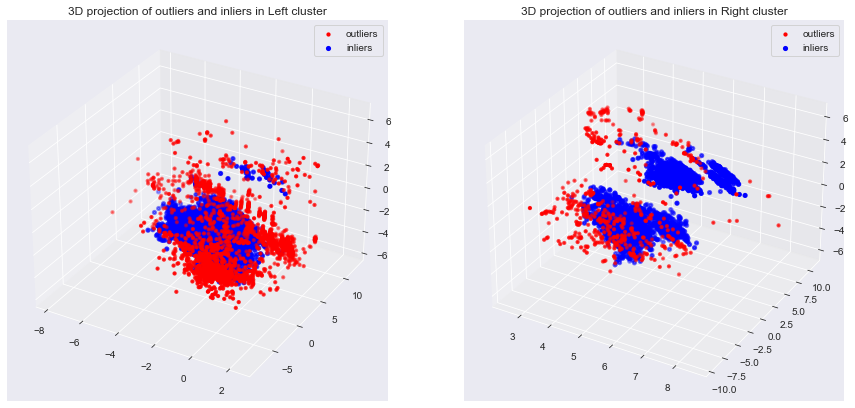

In [18]:
fig = plt.figure(figsize = (15,10))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_3d_QuantileTransformer[outliers_idx_l, 0], pca_3d_QuantileTransformer[outliers_idx_l, 1], pca_3d_QuantileTransformer[outliers_idx_l, 2],
           s= 5, linewidths = 2 , marker= "o", c="red", label="outliers")
ax.scatter(pca_3d_QuantileTransformer[inliers_idx_l, 0], pca_3d_QuantileTransformer[inliers_idx_l, 1], pca_3d_QuantileTransformer[inliers_idx_l, 2], 
           s=10, linewidths = 2, marker="o", label="inliers",c= "b")
plt.title("3D projection of outliers and inliers in Left cluster")
ax.legend()

ax = fig.add_subplot(122, projection='3d')
ax.scatter(pca_3d_QuantileTransformer[outliers_idx_r, 0], pca_3d_QuantileTransformer[outliers_idx_r, 1], pca_3d_QuantileTransformer[outliers_idx_r, 2],
           s= 5, linewidths = 2 , marker= "o", c="red", label="outliers")
ax.scatter(pca_3d_QuantileTransformer[inliers_idx_r, 0], pca_3d_QuantileTransformer[inliers_idx_r, 1], pca_3d_QuantileTransformer[inliers_idx_r, 2], 
           s=10, linewidths = 2, marker="o", label="inliers",c= "b")
plt.title("3D projection of outliers and inliers in Right cluster")
ax.legend()
plt.show()

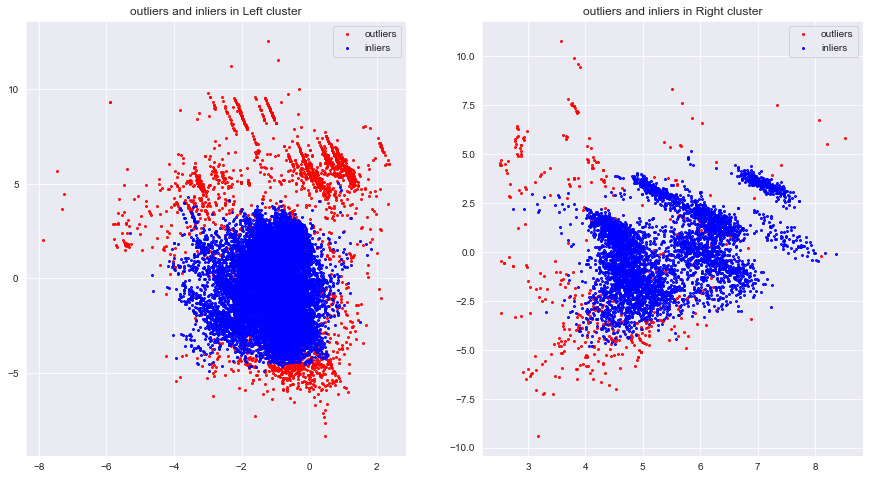

In [19]:
fig = plt.figure(figsize = (15,8))

ax = fig.add_subplot(121)
plt.scatter(pca_3d_QuantileTransformer[outliers_idx_l, 0], pca_3d_QuantileTransformer[outliers_idx_l, 1],
                s= 1, linewidths = 2 , marker= "o", c="red", label="outliers")
plt.scatter(pca_3d_QuantileTransformer[inliers_idx_l, 0], pca_3d_QuantileTransformer[inliers_idx_l, 1], 
                s=1, linewidths = 2, marker="o", label="inliers",c= "b")
plt.legend()
plt.title("outliers and inliers in Left cluster")

ax = fig.add_subplot(122)
plt.scatter(pca_3d_QuantileTransformer[outliers_idx_r, 0], pca_3d_QuantileTransformer[outliers_idx_r, 1],
                s= 1, linewidths = 2 , marker= "o", c="red", label="outliers")
plt.scatter(pca_3d_QuantileTransformer[inliers_idx_r, 0], pca_3d_QuantileTransformer[inliers_idx_r, 1], 
                s=1, linewidths = 2, marker="o", label="inliers",c= "b")
plt.legend()
plt.title("outliers and inliers in Right cluster")
plt.show()